# MIE 1613 A4
- Due Date: 2023-04-10
- Name: William Hazen
- Student ID: 1009231225
- Department: MIE
- Program: M.Eng.

In [143]:
import SimFunctions
import SimClasses
import SimRNG
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
from scipy.stats import probplot, kstest
from scipy.stats.distributions import norm, expon, erlang, lognorm, triang
warnings.filterwarnings("ignore")
# fix random number seed
np.random.seed(1)

# Problem 1

## **P1 Logic:**  
- This question is a modified MG1 example from section 4.3. I first wanted to determine the warmup period to find the steady state of the system, to which I initally used d = 1000 for our 200,000 samples. After plotting the cumlative average (dividing the sum by the current j [where j is looping between d and 200,000]) I found that around 60,000 to 100,000 the plot seems relativley flat, whereas the values before seemed sporadic. I after isolating the plot I choose the warmup period to be 90,000.

- From here, to find the 95% CI for the 0.85th quantile, I got 55 batch between the values of d = 90,000 and m = 200,000 with 2000 samples in each batch. I then got the 0.85th index and took a 95% CI by using the formula shown in the normal approx image.


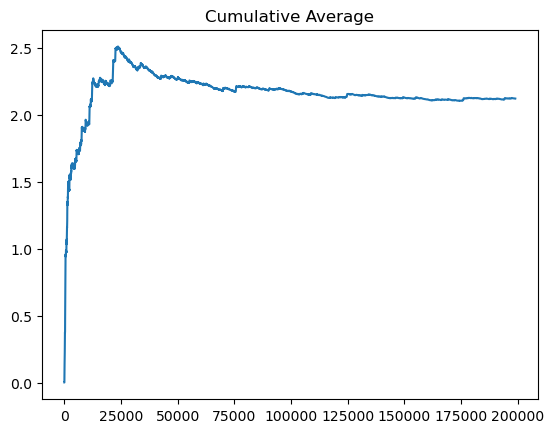

In [144]:
ZRNG = SimRNG.InitializeRNSeed()
WaitTimeAvg = []
# Parameters to specify
# Units are in minutes
MeanTBA = 1.0  # mean time-between-arrivals
MeanST = 0.8  # mean service time
Phases = 3  # nu mber of Erlang distribution phases
m = 200000  # number of customers to simulate
d = 1000 # Number of simulation experiment replications
NumReps = 1
Cum_Avg = []
for Rep in range(NumReps):
    Y = 0
    SumY = 0
    
    # # Warm-up period -- these waiting times
    # # are not saved or recorded
    for i in range(0, d):
        A = SimRNG.Expon(MeanTBA, 1)
        X = SimRNG.Erlang(Phases, MeanST, 2)
        Y = max(0, Y + X - A)

    # End of warm-up period -- these waiting times
    # are kept and used for estimation
    for j in range(d, m):
        A = SimRNG.Expon(MeanTBA, 1)
        X = SimRNG.Erlang(Phases, MeanST, 2)
        Y = max(0, Y + X - A)
        SumY = SumY + Y
        Cum_Avg.append(SumY / j)
    
    plt.plot(Cum_Avg)
    plt.title("Cumulative Average") 
    plt.show()
#     WaitTimeAvg.append(SumY/(float(m-d)))
# WaitTimeAvg = pandas.DataFrame({"WaitTimeAvg": WaitTimeAvg})
# print("Means")
# print(WaitTimeAvg.mean())


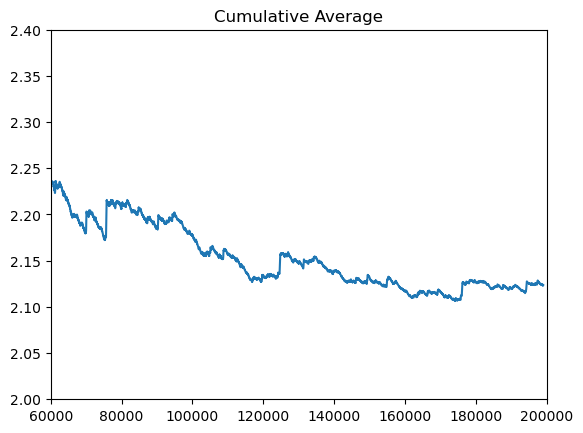

In [145]:
plt.plot(Cum_Avg)
plt.title("Cumulative Average")
plt.xlim([60000, 200000])
plt.ylim([2, 2.4])
plt.show()

- it appears that somewhere around 90,000 is where the average waiting times seem to var around the central value 2-2.1, therefore we can take d=90,000 and m=200,000

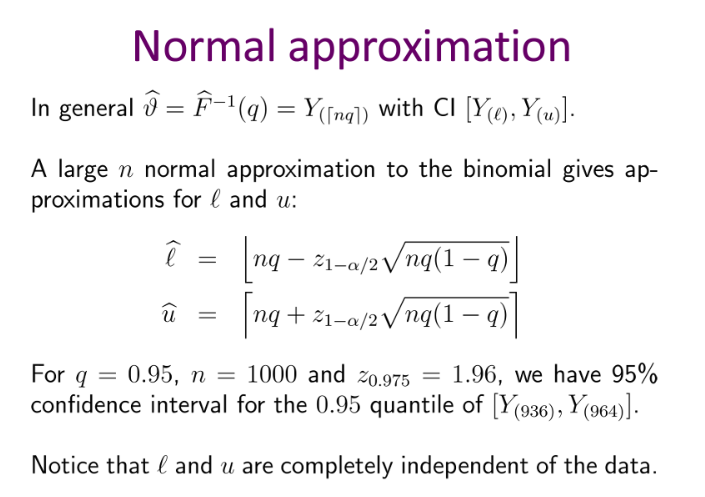

In [146]:
d = 90000 
m = 200000 
batch_size = 2000

n = (m-d) // batch_size
print(n)
q = 0.85
z = 1.96

lower_q = n*q - z * np.sqrt(n*q*(1-q))
upper_q = n*q + z * np.sqrt(n*q*(1-q))
print(np.floor(lower_q)-1, np.ceil(upper_q)-1)

55
40.0 51.0


In [147]:
ZRNG = SimRNG.InitializeRNSeed()
WaitTimeAvg = []
# Parameters to specify
# Units are in minutes
MeanTBA = 1.0  # mean time-between-arrivals
MeanST = 0.8  # mean service time
Phases = 3  # number of Erlang distribution phases

d = 90000  # number of customers in warm-up period
m = 200000  # number of customers to simulate

# Number of simulation experiment replications
NumReps = 1

# Batch size
batch_size = 2000
n = (m-d)//batch_size
batch_Sum_Y = []
WaitTimeAvg = []

np.random.seed(1)

for Rep in range(NumReps):
    # Warm-up period -- these waiting times are not saved or recorded
    for i in range(0, d):
        A = SimRNG.Expon(MeanTBA, 1)
        X = SimRNG.Erlang(Phases, MeanST, 2)
        Y = max(0, Y + X - A)

    for i in range(n):
        Y = 0
        SumY = 0
        
        for j in range(i*batch_size+d, (i+1)*batch_size+d):
            A = SimRNG.Expon(MeanTBA, 1)
            X = SimRNG.Erlang(Phases, MeanST, 2)
            Y = max(0, Y + X - A)
            SumY = SumY + Y
            
        #batch_Sum_Y.append(SumY)
        WaitTimeAvg.append(SumY/(float(batch_size)))

q = 0.85
z = 1.96

quantile_index = int(np.ceil(len(WaitTimeAvg)*q)-1)
lower_q = int(np.floor(n*q - z * np.sqrt(n*q*(1-q)))-1)
upper_q = int(np.ceil(n*q + z * np.sqrt(n*q*(1-q)))-1)

sorted_que = np.sort(WaitTimeAvg)
CI_95 = sorted_que[quantile_index]
lower_CI_95 = sorted_que[lower_q]
upper_CI_95 = sorted_que[upper_q]

print("WaitTimeAvg 0.85 quantile:", CI_95)
print("Lower CI 95:", lower_CI_95)
print("Upper CI 95:", upper_CI_95)


WaitTimeAvg 0.85 quantile: 2.521870500333212
Lower CI 95: 2.3081888057665596
Upper CI 95: 2.6958261107734605


## **P1 Results:**  

- The results for the 0.85th quantile of the WaitTimeAvg for the steady state waiting times was approx 2.45-2.55 [(-) 2.25-2.35, (+) 2.95-3.05]

# Problem 2

## **P2 Logic:**  

- I modified MG1 to become M/G/inf, where I created 2 new classes for the Inventory and Order so I can keep track of the process more efficently. I then created several functions to keep track of different components such as scheduling the Orders, Demands, and Order Arrivals while calcualting the holding and backlog cost and the total cost which is dependent of the inventory size and cost per item. The simulation works as follows, for a given (s,S) policy I initally schedual 120 (order per month) and the Demands to which the time between each demand are IID and exponetial random variables with a mean of 0.1 per month. The demands are scheduled according to the probability distribuition given for D, now this process of scheduling and order and demand are repeated 120 times where we can get the item cost of the order and the total cost (which includes holding and backlog costs) while accounting for the Order_Arrival. When an order is called it goes through a series of functions, For example, Order() will give the size of the order and schedule an arrival or when the order will be fufilled to which the Inventory class will reclaim a position and the order class will remove it from its queue. The Demand() gives the size of the items (Z) given by the probability of D and removes that many items from the inventory. Now to account for the holding and blacklog cost, the Expected_cost() function see if the current size of the inventory is greater than zero, if it is then the holding cost is calcuated by the max(current_inventory size, 0) if the size is less than 0 then the backlog cost is calculated by 5* max(-1* current inventory size, 0). In the Expected_cost() the cost adds the values produced by either function. To calculate the expected cost over 120 months, the SimRNG.Clock has values in discrete times, so to calculate the time average I summed the average ordering cost, and the cost from the Expected_cost() which includes the average holding cost and the average backlog cost for each month.



## **Q2 a)**  

In [333]:
# Classes
class Inventory_Class:
    def __init__(self, current_inventory):
        self.inventory = current_inventory

    def add_inventory(self, N_Inventory):
        self.inventory = self.inventory + N_Inventory

    def remove_inventory(self, N_Inventory):
        self.inventory = self.inventory - N_Inventory

class Order_Class:
    def __init__(self):
        self.Z_items = None

    def add_order(self, z_size):
        self.Z_items = z_size

    def remove_order(self):
        self.Z_items = None

In [488]:
n_reps = 1

ZSimRNG = SimRNG.InitializeRNSeed()
Calendar = SimClasses.EventCalendar()

TheQueues = []
TheCTStats = []
TheDTStats = []
TheResources = []


#############################################
# Functions
def SizeOfDemand():
    U = SimRNG.Uniform(0, 1, 10)
    if U > 1/2:
        U = SimRNG.Uniform(0, 1, 11)
        D = 2 if U > 1/3 else 1
    else:
        U = SimRNG.Uniform(0, 1, 12)
        D = 3 if U > 1/3 else 4
    return D

def SizeOfOrder(s, S, I):
    if I < s:
        Z = S - I
    else:
        Z = 0
    return Z

def Order_Cost(Z, K, i):
    Z_cost = K + i*Z
    return Z_cost

def Order(s, S, K, i):
    Z_Size = SizeOfOrder(s, S, I=Inventory_C.inventory)
    Z_cost = Order_Cost(Z_Size, K, i)
    Orders_C.add_order(Z_Size)
    SimFunctions.Schedule(Calendar, "Order_Arrival", SimRNG.Uniform(0.5, 1, 4))
    return Z_cost

def Demand():
    Z_items = SizeOfDemand()
    Inventory_C.remove_inventory(Z_items)
    SimFunctions.Schedule(Calendar, "Demand", SimRNG.Expon(0.1, 3))

def Order_Arrival():
    if Orders_C.Z_items is not None:
        Inventory_C.add_inventory(Orders_C.Z_items)
        Orders_C.remove_order()

def Holding_cost(cost, Inventory_C):
    I_ps = max(Inventory_C.inventory, 0)
    cost = 1 * I_ps
    return cost, I_ps

def Backlog_cost(cost, Inventory_C):
    I_ng = max((-1 * Inventory_C.inventory), 0)
    cost = 5 * I_ng
    return cost, I_ng

def Expected_cost(cost, Inventory_C, I_ps, I_ns):
    I_ps = 0
    I_ng = 0
    if Inventory_C.inventory >= 0:
        ind_cost, I_ps = Holding_cost(cost, Inventory_C)
    else:
        ind_cost, I_ng = Backlog_cost(cost, Inventory_C)
    cost = cost + ind_cost
    return cost, ind_cost, I_ps, I_ng


############################################
# Simulation
for reps in range(0, n_reps, 1):
    
    #############################################
    # Intances
    K = 32  # setup cost
    i_cost = 3  # incremental cost per item ordered
    T = 120  # 120 months
    I_0 = 60  # inital invistory level

    cost = 0
    Z_cost = 0
    I_ps = 0
    I_ng = 0

    s = [20, 20, 20, 20, 40, 40, 40, 60, 60]
    S = [40, 60, 80, 100, 60, 80, 100, 80, 100]

    ############################################
    Inventory_C = Inventory_Class(I_0)
    Orders_C = Order_Class()

    inventory_list = []
    time_list = []
    Z_cost_list = []
    Total_cost_list = []
    inv_cum_cost_list = []
    inv_per_cost_list = []
    I_ps_list = []
    I_ng_list = []


    
    SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    for time in range(1, T):
        SimFunctions.Schedule(Calendar, "Order", time)
    SimFunctions.Schedule(Calendar, "Demand", SimRNG.Expon(0.1, 1))
        
    SimFunctions.Schedule(Calendar, "EndSimulation", T)
    NextEvent = Calendar.Remove()
    if NextEvent.EventType == "Demand":
        Demand()
        
    SimClasses.Clock = NextEvent.EventTime

    while NextEvent.EventType != "EndSimulation":
        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        end_time = SimClasses.Clock
        if NextEvent.EventType == "Demand":
            Demand()
        elif NextEvent.EventType == "Order":
            Z_cost = Order(s[1], S[1], K, i_cost)
        elif NextEvent.EventType == "Order_Arrival":
            Order_Arrival()

        Z_cost_list.append(Z_cost)
        cost, per_cost, I_ps, I_ng = Expected_cost(cost, Inventory_C, I_ps, I_ng)
        inventory_list.append(Inventory_C.inventory)
        time_list.append(SimClasses.Clock)
        Total_cost_list.append(cost+Z_cost)
        inv_cum_cost_list.append(cost)
        inv_per_cost_list.append(per_cost)
        I_ps_list.append(I_ps)
        I_ng_list.append(I_ng)
        
df = pd.DataFrame({"I(t)": inventory_list, 
                   "I(t)^+": I_ps_list,
                   "I(t)^-": I_ng_list,
                   "Time": time_list , 
                   "Total Cost": Total_cost_list,
                   "Accumalated Inventory Cost": inv_cum_cost_list, 
                   "Inventory Cost": inv_per_cost_list, 
                   "Z items Cost": Z_cost_list, 
                   })
# time average

averages = []
for i in range(1, 121):
    j = next((idx for idx, val in enumerate(df["Time"]) if val > i), len(df["Time"]))
    avg = df["Total Cost"][i:j].mean()
    averages.append(avg)
    
print(f"Expected cost of s = 20 & S = 60: ${np.mean(averages)}")

Expected cost of s = 20 & S = 60: $12357.953934978043


In [489]:
df

,I(t),I(t)^+,I(t)^-,Time,Total Cost,Accumalated Inventory Cost,Inventory Cost,Z items Cost
0,56,56,0,0.325165,56,56,56,0
1,53,53,0,0.379502,109,109,53,0
2,51,51,0,0.408590,160,160,51,0
3,49,49,0,0.668183,209,209,49,0
4,46,46,0,0.718764,255,255,46,0
...,...,...,...,...,...,...,...,...
1410,-1,0,1,119.625682,42544,42377,5,167
1411,-4,0,4,119.662676,42564,42397,20,167
1412,41,41,0,119.678629,42605,42438,41,167
1413,39,39,0,119.732785,42644,42477,39,167


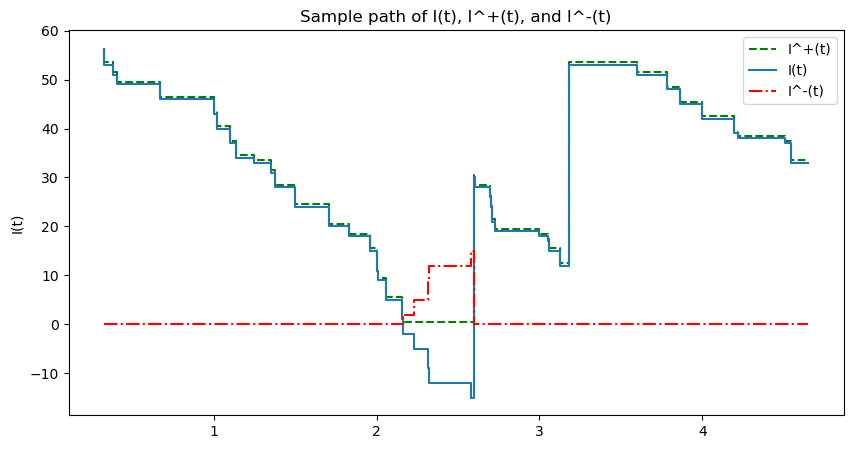

In [497]:
plt.figure(figsize=(10, 5))
plt.step(time_list[:50], np.array(df["I(t)^+"][:50])+0.5, c='g', linestyle='--', label='I^+(t)')
plt.step(time_list[:50], df["I(t)"][:50], label='I(t)')
plt.step(time_list[:50], df["I(t)^-"][:50], c='r', linestyle='-.', label='I^-(t)')
plt.ylabel('I(t)')
plt.legend()
plt.title("Sample path of I(t), I^+(t), and I^-(t)")
plt.show()


## **Q2 b)**  

In [499]:
n_reps = 500

ZSimRNG = SimRNG.InitializeRNSeed()
Calendar = SimClasses.EventCalendar()

TheQueues = []
TheCTStats = []
TheDTStats = []
TheResources = []

AllQueueLength = []

#############################################
# Functions


def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a, ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return f"${m} +/- ${hw}"


############################################
Inventory_C = Inventory_Class(I_0)
Orders_C = Order_Class()
total_averages = []

############################################
# Simulation
for reps in range(0, n_reps, 1):
    #############################################
    # Intances
    K = 32  # setup cost
    i_cost = 3  # incremental cost per item ordered
    T = 120  # 120 months
    I_0 = 60  # inital invistory level
    S_ = 0
    SLast = 0
    Clock = 0.0
    TLast = 0.0
    Area = 0.0

    cost = 0
    Z_cost = 0
    I_ps = 0
    I_ng = 0

    s = [20, 20, 20, 20, 40, 40, 40, 60, 60]
    S = [40, 60, 80, 100, 60, 80, 100, 80, 100]

    inventory_list = []
    time_list = []
    Z_cost_list = []
    Total_cost_list = []
    inv_cum_cost_list = []
    inv_per_cost_list = []
    I_ps_list = []
    I_ng_list = []

    SimFunctions.SimFunctionsInit(
        Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    for time in range(1, T):
        SimFunctions.Schedule(Calendar, "Order", time)
    SimFunctions.Schedule(Calendar, "Demand", SimRNG.Expon(0.1, 1))

    SimFunctions.Schedule(Calendar, "EndSimulation", T)
    NextEvent = Calendar.Remove()
    if NextEvent.EventType == "Demand":
        Demand()

    SimClasses.Clock = NextEvent.EventTime

    while NextEvent.EventType != "EndSimulation":
        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        end_time = SimClasses.Clock
        if NextEvent.EventType == "Demand":
            Demand()
        elif NextEvent.EventType == "Order":
            Z_cost = Order(s[0], S[0], K, i_cost)
        elif NextEvent.EventType == "Order_Arrival":
            Order_Arrival()

        Z_cost_list.append(Z_cost)
        cost, per_cost, I_ps, I_ng = Expected_cost(
            cost, Inventory_C, I_ps, I_ng)
        inventory_list.append(Inventory_C.inventory)
        time_list.append(SimClasses.Clock)
        Total_cost_list.append(cost+Z_cost)
        inv_cum_cost_list.append(cost)
        inv_per_cost_list.append(per_cost)
        I_ps_list.append(I_ps)
        I_ng_list.append(I_ng)
        clock = SimClasses.Clock
        
    df = pd.DataFrame({"I(t)": inventory_list,
                       "I(t)^+": I_ps_list,
                       "I(t)^-": I_ng_list,
                       "Time": time_list,
                       "Total Cost": Total_cost_list,
                       "Accumalated Inventory Cost": inv_cum_cost_list,
                       "Inventory Cost": inv_per_cost_list,
                       "Z items Cost": Z_cost_list,
                       })
    
    #time average
    averages = []
    avg = 0
    for i in range(1, 121):
        j = next((idx for idx, val in enumerate(time_list) if val > i), len(time_list))
    avg = np.mean(Total_cost_list[i:j])
    averages.append(avg)

    total_averages.append(averages)

AllQueueLength.append(QueueLength.Mean())

print(f"CI 95 of s = 20 & S = 40: {CI_95(total_averages)}")  

CI 95 of s = 20 & S = 40: $23357.004383754906 +/- $221.51884104093162


## **Q2 c)**  

## **P2 Results:**  



# Problem 3

## **P3 Logic:**  
3a)
- To estimate the gradient of E[Y(x)] of the SAN simulation I first used the Finite difference method which estimates the difference between the mean time to complete a prokect for scenarios (x+delta_x) and x. This was done by doing 5 loops, 1 for each value of xj where I changed the x[j] = x[j] + delta_x where it will then be passed through repetitions. There are two different Y's that calculate the max path of A(x) and A(x + delta_x) separately using Common Random Numbers. I then calculate the gradient for the respective x[j] by subracting the Y_(x + delta_x) - Y_x / delta_x to get the finite difference to which I take the sample average (though the CI95) and the sample variance. 

3b)
- To estimate the gradient of E[Y(x)] of the SAN simulation using Infinitesimal Perturbation Analysis, I made cases for each value of x. In the case of x[j] if j = 1, then the IPA is calcualted by the A[j]/x[j] * *I*. *I* is an indicator function such that if A[j] is not on the maximum path then *I* is equal to 0. After 5 loops, I took the sample average (though the CI95) and the sample variance for each IPA of xj. 

3c)
- For the stocasitc approximation search, I first notabley used the finite difference method from 3a to calculate the gradient which will be used to find the optimal activity means through the formula x = x - alpha*gradient. As this is a search, I initalized contraints being a cost function (cj * (tj - xj)) where the cost must be less than or equal to the budget b and the value of xj > lj where lk is the smallest achievable mean activity time for activity j. If any of these constraints are broken the loop will stop, and the result should be the optimal activity mean time where the budjet is close to being fully utalized. To note, the alpha was updated each repetition by dividing the inital value by the number of reps to which each step gets larger. 


## **3a)** FD

In [515]:
def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a, ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return m, "+/-", hw


np.random.seed(1)

N = 200
delta_x = 0.1
x = [0.5, 1, 0.7, 1, 1]
x_dx = [0.5, 1, 0.7, 1, 1]


print("Estimate Gradient of E[Y(x)] using Finite Difference (FDA)\n")

for j in range(0, 5, 1):
    Y_list = []
    Y_dx_list = []
    E_FD_list = []
    Var_DF_list = []
    
    xx_dx = [0.5, 1, 0.7, 1, 1]
    xx_dx[j] = x_dx[j] + delta_x
    SumFD = 0
    
    for rep in range(0, N, 1):
        U = np.random.random(5)
        X = []
        X_dx = []
        for i in range(0, 5, 1):
            X.append(-np.log(1-U[i])*x[i])
            X_dx.append(-np.log(1-U[i])*xx_dx[i])
            
        P1 = X[0] + X[3]
        P2 = X[0] + X[2] + X[4]
        P3 = X[1] + X[4]
        
        P1_dx = X_dx[0] + X_dx[3]
        P2_dx = X_dx[0] + X_dx[2] + X_dx[4]
        P3_dx = X_dx[1] + X_dx[4]
        
        Y = max(P1, P2, P3)
        Y_list.append(Y)
        Y_dx = max(P1_dx, P2_dx, P3_dx)

        Y_dx_list.append(Y_dx)
        FD = (Y_dx - Y) / delta_x
        #SumFD = SumFD + FD #/ (rep+1)
        E_FD_list.append(FD)

        Var_DF = (Y_dx - Y)
        Var_DF_list.append(Var_DF)
    
    std = np.std(E_FD_list,ddof=1)    
    
    ci = std/np.sqrt(len(E_FD_list))

    print("for x_{} || 95% Confidence Intervals || Mean {} || Variance = {} +/- {} \n".format(j+1, CI_95(E_FD_list), np.var(E_FD_list, ddof=1), 1.96*ci))

Estimate Gradient of E[Y(x)] using Finite Difference (FDA)

for x_1 || 95% Confidence Intervals || Mean (0.7139447969696501, '+/-', 0.14871932853383682) || Variance = 1.1514701519968396 +/- 0.14871932853383682 

for x_2 || 95% Confidence Intervals || Mean (0.7466091531771284, '+/-', 0.15850151521495615) || Variance = 1.3079305667137118 +/- 0.15850151521495612 

for x_3 || 95% Confidence Intervals || Mean (0.6260472937902022, '+/-', 0.14873424988979955) || Variance = 1.1517012229425936 +/- 0.14873424988979952 

for x_4 || 95% Confidence Intervals || Mean (0.5233520173916774, '+/-', 0.15566273492068222) || Variance = 1.2614997419297476 +/- 0.15566273492068225 

for x_5 || 95% Confidence Intervals || Mean (0.9133851946610959, '+/-', 0.15381738464840458) || Variance = 1.231767379220911 +/- 0.1538173846484046 



## **3b)** IPA

In [516]:
def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a, ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return m, "+/-", hw

np.random.seed(1)

N = 200
d_x = 0.1

# Choose the value of x (corresponding to x1 in the notation used in the slides)
delta_x = 0.1
x = [0.5, 1, 0.7, 1, 1]

print("Estimate Gradient of E[Y(x)] using Infinitesimal Perturbation Analysis (IPA)\n")


for j in range(0, 5, 1):
    IPA = 0
    Y_list = []
    Y_dx_list = []
    E_ID_list = []
    Var_DF_list = []
    for rep in range(0, N, 1):
        U = np.random.random(5)
        X = []
        X_dx = []
        
        for i in range(0, 5, 1):
            X.append(-np.log(1-U[i])*x[i])
        
        P1 = X[0] + X[3]
        P2 = X[0] + X[2] + X[4]
        P3 = X[1] + X[4]
        Y = max(P1, P2, P3)
        Y_list.append(Y)

        if j == 0:
            I = (Y == P1) or (Y == P2)
            IPA = (X[j] / x[j]) * I
            
        elif j == 1:
            I = (Y == P3)
            IPA = (X[j] / x[j]) * I
        
        elif j == 2:
            I = (Y == P2)
            IPA = (X[j] / x[j]) * I
        
        elif j == 3:
            I = (Y == P1)
            IPA = (X[j] / x[j]) * I
            
        elif j == 4:
            I = (Y == P2) or (Y == P3)
            IPA = (X[j] / x[j]) * I
                
        E_ID_list.append(IPA)   

    std = np.std(E_ID_list, ddof=1)

    ci = std/np.sqrt(len(E_ID_list))

    print("for x_{} || 95% Confidence Intervals || Mean {} || Variance = {} +/- {} \n".format(j + 1, CI_95(E_ID_list), np.var(E_ID_list, ddof=1), 1.96*ci))


Estimate Gradient of E[Y(x)] using Infinitesimal Perturbation Analysis (IPA)

for x_1 || 95% Confidence Intervals || Mean (0.692449340761912, '+/-', 0.1466299577260191) || Variance = 1.1193432165105242 +/- 0.1466299577260191 

for x_2 || 95% Confidence Intervals || Mean (0.7183084107182407, '+/-', 0.1581221947472548) || Variance = 1.3016778671224896 +/- 0.1581221947472548 

for x_3 || 95% Confidence Intervals || Mean (0.6116932693932781, '+/-', 0.14929312863587055) || Variance = 1.1603726706521549 +/- 0.14929312863587055 

for x_4 || 95% Confidence Intervals || Mean (0.5099728015079559, '+/-', 0.1558473533567174) || Variance = 1.2644938332097841 +/- 0.1558473533567174 

for x_5 || 95% Confidence Intervals || Mean (0.9042973526166337, '+/-', 0.1543339701025108) || Variance = 1.24005489002513 +/- 0.1543339701025108 



## **3c)** Stochastic Approximation

iter 0 | cost: 0 | E[Y(x)] = 3.427596935658125
iter 10 | cost: 0.3870002192080485 | E[Y(x)] = 3.1461522869928182
iter 20 | cost: 0.5206644904566147 | E[Y(x)] = 3.048144744775104
iter 30 | cost: 0.6104155293900524 | E[Y(x)] = 2.982230080167649
iter 40 | cost: 0.6796698590946302 | E[Y(x)] = 2.931363081030742
iter 50 | cost: 0.7367583182195149 | E[Y(x)] = 2.8894044339432075
iter 60 | cost: 0.7856863314778089 | E[Y(x)] = 2.853430995780675
iter 70 | cost: 0.8287230389471251 | E[Y(x)] = 2.82181204269051
iter 80 | cost: 0.8672775304581785 | E[Y(x)] = 2.793568543683136
iter 90 | cost: 0.9022927285768804 | E[Y(x)] = 2.7679099419715834
iter 100 | cost: 0.9344323449991401 | E[Y(x)] = 2.744387665725481
iter 110 | cost: 0.9641802357067198 | E[Y(x)] = 2.7226422223847018
iter 120 | cost: 0.9919068652554789 | E[Y(x)] = 2.702366447877651
END: iter 123 | cost: 0.9998758730181713 | E[Y(x)] = 2.696537774975888
Optimal activity mean times: [0.74679413 0.84671422 0.76644387 0.89253147 0.74501747]


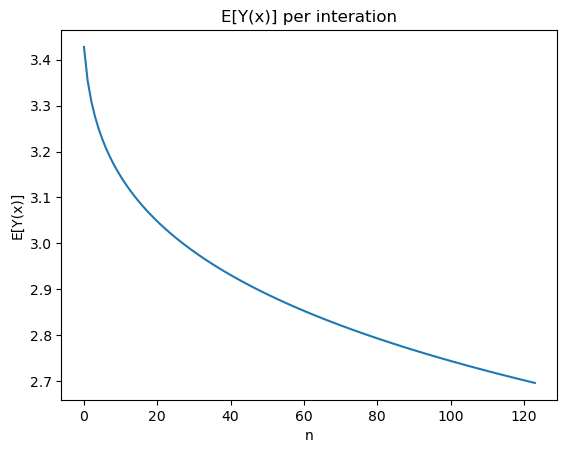

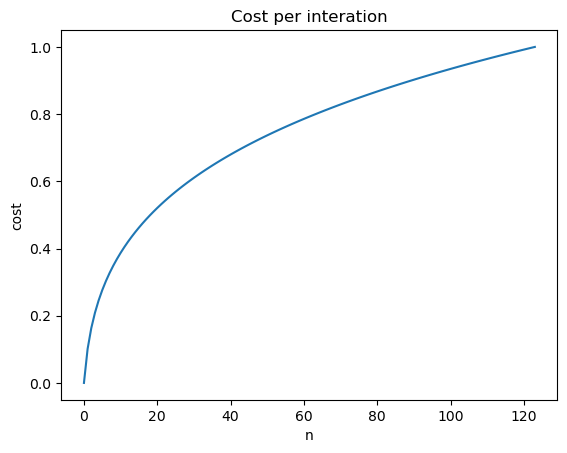

In [501]:
def FD(x, N):
    np.random.seed(1)
    delta_x = 0.1
    x_dx = [1, 1, 1, 1, 1]

    gradient_list = []
    YY_list = []

    for j in range(0, 5, 1):
        Y_list = []
        Y_dx_list = []
        E_FD_list = []

        xx_dx = x.copy()
        xx_dx[j] = x_dx[j] + delta_x
        SumFD = 0

        for rep in range(0, N, 1):
            U = np.random.random(5)
            X = []
            X_dx = []
            for i in range(0, 5, 1):
                X.append(-np.log(1-U[i])*x[i])
                X_dx.append(-np.log(1-U[i])*xx_dx[i])

            P1 = X[0] + X[3]
            P2 = X[0] + X[2] + X[4]
            P3 = X[1] + X[4]

            P1_dx = X_dx[0] + X_dx[3]
            P2_dx = X_dx[0] + X_dx[2] + X_dx[4]
            P3_dx = X_dx[1] + X_dx[4]

            Y = max(P1, P2, P3)
            Y_list.append(Y)
            Y_dx = max(P1_dx, P2_dx, P3_dx)

            Y_dx_list.append(Y_dx)
            FD = (Y_dx - Y) / delta_x
            # SumFD = SumFD + FD #/ (rep+1)
            E_FD_list.append(FD)
        
            YY_list.append(np.mean(Y_list))

        gradient_list.append(np.mean(E_FD_list))
            
    return gradient_list, YY_list

np.random.seed(1)

N = 150

t = [1, 1, 1, 1, 1]
c = [1, 1, 1, 1, 1]
l = [0.5, 0.5, 0.5, 0.5, 0.5]
b = 1

inter = []
d_x = 0.1
alpha_0 = 0.03

# Starting values
x = [1, 1, 1, 1, 1]

x_new_list = []
Y_list = []
cost_list = []
fd_list = []
EY_list = []
cost_l = []
c1 = False

for n in range(0, N, 1):

    cost_l = []
    # Calculate the gradient of E[Y(x)] using finite difference
       
    gradient, Y = FD(x, N)
    
    for j in range(5):
        cost_l.append(c[j] * (t[j] - x[j]))
        # check constraint
        if x[j] < l[j]:
            c1 = True
    cost = np.sum(cost_l)

    if cost > b:
        break

    if c1 == True:
        break

    # Update x_i+1
    alpha = alpha_0 / (n+1)
    x = x - alpha * np.array(gradient)

    inter.append(n)
    EY_list.append(np.mean(Y))
    fd_list.append(gradient)
    cost_list.append(cost)

    if n % 10 == 0:
        print("iter {} | cost: {} | E[Y(x)] = {}".format(n, cost, EY_list[n]))

print("END: iter {} | cost: {} | E[Y(x)] = {}".format(max(inter), cost_list[max(inter)], EY_list[max(inter)]))
print("Optimal activity mean times: {}".format(x))
plt.figure()
plt.plot(inter, EY_list)
plt.ylabel("E[Y(x)]")
plt.xlabel("n")
plt.title("E[Y(x)] per interation")
plt.show()

plt.figure()
plt.plot(inter, cost_list)
plt.ylabel("cost")
plt.xlabel("n")
plt.title("Cost per interation")
plt.show()


## **P3 Results:**  

- 3a) & 3b) produced very similar estimates where the FD had around a 0.01-0.02 higher difference in the graident values. When looking at the variance, the theorical results are apparent as the variance for both FD and IPA methods are high due to their sensitivity to model input/parameters.

- 3c) From both the plots of the expected value of Y(x) and cost for each interation to the optimal activity means times, we can see the progression of the stocastic approximation search. We can see a tradeoff in the plots where the E[Y(x)] plot is decending and the cost is ascending which implies that the search is correctly optimizing the activity mean times.

# Problem 4

## **P4 Logic:**  

- 4a) I took the inverse CDF and uniformly sampled values u to which I can create a distribution where I can same to get a similar distribution to the PDF. By sampling from the inverse CDF distribution I can get the demand D for the objection function which mimizes the expected total cost.

- 4b)/4c)

## **4a)**

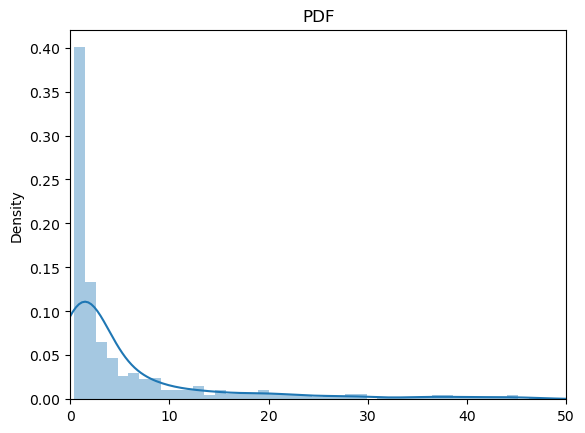

In [158]:
#pdf
n = 1000
f_x_list = []
np.random.seed(1)

for i in range(n):
    x = np.random.uniform(low=5)
    f_x = 50/(x**3)
    f_x_list.append(f_x)

sns.distplot(f_x_list)
plt.title("PDF")
plt.xlim([0, 50])
plt.show()

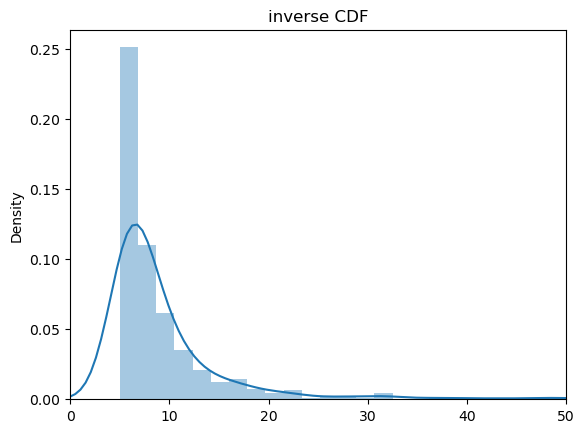

In [159]:
#inv_cdf
n = 1000
D_list = []
np.random.seed(1)

for i in range(n):
    u = np.random.random()
    D = 5/(np.sqrt(1-u))
    D_list.append(D)
    
sns.distplot(D_list)
plt.title("inverse CDF")
plt.xlim([0,50])
plt.show()

- Can see that the inverse CDF produces similar shape to the pdf of the function. By sampling the inverse CDF we can generate samples for our linear program, this method is also known as the inverse transform methods/sampling

## **4b)**

In [378]:
from scipy.optimize import minimize
from scipy.optimize import linprog

n = 50
c_0 = 1
c_u = 3

O_i = 0
U_i = 0

theta_list = []
order_size_list = []
fun_size_list = []

#np.random.seed(761)

def constraint(x, i, O_i, U_i):
    D_i = 5/(np.sqrt(1-np.random.random()))
    O_i += O_i >= (x - D_i)
    O_i += O_i >= 0

    U_i += U_i >= (D_i - x)
    U_i += U_i >= 0

    theta_i = c_0 * O_i + c_u * U_i
    return theta_i

def objective(x):
    O_i = 0
    U_i = 0
    total_theta = 0
    for i in range(n):
        theta_i = constraint(x, i, O_i, U_i)
        theta_list.append(theta_i)
    return np.mean(theta_list)

x0 = np.random.uniform(low=0, high=50)
result = minimize(objective, x0)

#print(result)
print('Minimum Objective: ', result.fun)


Minimum Objective:  6.96


In [371]:
D_i = 5/(np.sqrt(1-(c_u/(c_0 + c_u))))
print("Exact Solution =", D_i)


Exact Solution = 10.0


## **P4 Results:**  

